# Are you DTFind Variation in OkCupid Profiles using NLP and Classification?

# Ethical Considerations

There are a few things that we took into account before starting our analysis of this dataset. We broke them up into 5 parts: anonymity, stereotypes, misinterpretation, maximizing effectiveness of a dating profile, and giving credence to the zodiac. Each are given a brief treatment below.  

### Anonymity

Anonymity was initially a problem with this dataset as it **included the usernames of the profiles**, but the version we are using had said usernames removed. Despite there being no username present, it is still possible that someone might recognize a profile that they saw in one of two ways. First, they recognize the profile from **their own use of the OkCupid app**. This does not seem like a very serious issue as dating profiles are semi-public, and there is an expectation that the user of the app knows that this information is going to be somewhat public. The other way a profile could be recognized is for the profile to have **some identifying information in one of the essays**. Examples could include a link to a Facebook page, an email address, or a first and last name. Since this dataset is rather old, most of the damage that could have been done has most likely already happened, and our use of it will probably not perpetuate any potential future invasions of privacy.

### Stereotypes

Since we are trying to predict the gender of the account as well and stated religious affiliation, it is conceivable that this could enforce gender and religious stereotypes that some might find harmful. We are approaching this data fairly agnostically and **did not really impose or seek to test any particular view** of gender onto the dataset. It is entirely possible that what we find goes against said stereotypes, thus showing that they are not accurate. Also, even if we could very accurately predict whether or not an account is marked as male or female using the essay and other factors, that doesn't say much of anything. For example, it does nothing to challenge/affirm gender as a social construct or as a binary category. **Our goal is simply to see if there are significant differences** in those profiles and whether or not it is predictive. As far as the religious categories go, we are not making statements about any particular religion, but whether or not certain stated behaviors (drinking and drug use) correlate with stated religiousness or not. As with gender, it is entirely **possible that we will find information that does not cohere to general tropes** about religious people.

### Misinterpretation
Misinterpretation is always a possibility, and **we will do our best to clearly state** what our results do and do not mean, thus minimizing the potential for misunderstanding. There is always a possibility that someone could maliciously use our analysis in some creative way that we hadn’t counted on, but that harm potential seems very low. 

### Maximizing a Dating Profile

This is a non-issue as **we have no data as to what makes an account more popular than any other.** Someone could not try to maximize their dating prospects using our analysis if they tried.

### This gives credence to Zodiacal Sign

For one small part, we tried to see if we could get some sort of clustering of zodiac signs. This was more for fun than anything else, but it might give the impression that zodiac signs are to be taken seriously. **No such endorsement is intended on our part**, and if anything, we will demonstrate that at least in some small way that zodiacal signs don’t do very much, or we might find some spurious correlation. Either way, it is doubtful that this will be a serious issue. What’s more, if someone is truly convinced that the zodiac indeed influences personality or the world at large, it seems doubtful that we will do very much to change their mind.

In [1]:
import time
t1 = time.time()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
import math
import re

from scipy import stats, misc
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize

from sklearn import tree, metrics, svm
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import *
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


#!pip install nltk

raw = pd.read_csv('profiles.csv')


## Importing and cleaning the data

The data as is was **relatively messy** and contained a lot of leftovers from the webscraping, such as new line indicators as well as indicators for page breaks. Fortunately, this was fairly easy to clean up as most of it was consistent throughout the data. We were able to come up with some **fairly straightforward find and replace commands** to get rid of the noise. 

In [3]:
# cleaning up html stuff leftover from scraping

df = raw.replace(to_replace="&rsquo;", value="'",regex=True)
df = df.replace(to_replace="<br />", value="",regex=True)
df = df.replace(to_replace="\n", value=" ",regex=True)
df = df.replace(to_replace="href", value="",regex=True)
df = df.replace(to_replace="ilink", value="",regex=True)
df.head()


,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn't have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn't have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn't matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn't want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


## NLP: Vocabulary Variation by Gender

One of our goals is to see if we can find significant differences between the profiles marked at male or female. This could be done using factors like height, but also by **parsing the "about me" essays and doing some cursory natural language processing** on them. We first separated the profiles marked as male and female and put them into separate data frames.

In [4]:
# creating separate dataframes for male/female profiles

males = df[df["sex"] == 'm']
females = df[df["sex"] == 'f']


In [5]:
# defining a function so it's easy to apply to both data sets

def analyze(data):
    # remove any profiles that did not complete the 'about me' essay 
    data_new = data['essay0'].dropna()
    
    #count how many were removed and print
    full = len(data)
    no_na = len(data_new)
    num_removed = full - no_na
    print("Total number of essays: " + str(full))
    print("Number of essays lost is: " + str(num_removed))
    
    # setting stop words standard
    stop_words = set(stopwords.words('english'))
    
    # tokenizer to split the data into a list of lists
    tokenizer = RegexpTokenizer(r'\w+')
    data_new = data_new.apply(lambda x: tokenizer.tokenize(x.lower()))
    
    # list needs to be flattened before we can work with it further
    flattened = [item for sublist in data_new for item in sublist]
    
    # now get a frequency distribution for all the words used in the essays
    fdist = nltk.FreqDist(flattened)
    most_common = fdist.most_common(1000)
    
    # we will remove stopwords/punctuation to get a better idea of unique words
    filtered_words = [word_tuple for word_tuple in most_common if word_tuple[0].lower() not in stop_words]
    filtered_words = [word_tuple for word_tuple in filtered_words if word_tuple[0].isalpha()]
    
    # make into df for ease of further analysis
    common_words = pd.DataFrame(filtered_words)
    common_words.rename(columns={0:"Most Common Words", 1:"Frequency"}, inplace=True)
    
    # normalize # of times the word was used by # of profiles
    common_words["Frequency"] = common_words["Frequency"]/no_na
    
    return common_words, data_new


In [6]:
# run on male profiles
male_most_common, male_tokenized = analyze(males)

male_most_common.head()


Total number of essays: 35829
Number of essays lost is: 3181


,Most Common Words,Frequency
0,like,0.809054
1,love,0.706169
2,life,0.496171
3,people,0.468941
4,interests,0.442753


In [7]:
# this is what the tokenized essays look like

male_tokenized[0:5]


0    [about, me, i, would, love, to, think, that, i...
1    [i, am, a, chef, this, is, what, that, means, ...
2    [i, m, not, ashamed, of, much, but, writing, p...
3       [i, work, in, a, library, and, go, to, school]
4    [hey, how, s, it, going, currently, vague, on,...
Name: essay0, dtype: object

In [8]:
female_most_common, female_tokenized = analyze(females)
female_most_common.head()


Total number of essays: 24117
Number of essays lost is: 2307


,Most Common Words,Frequency
0,love,1.122513
1,like,0.824392
2,life,0.575103
3,people,0.527006
4,new,0.453324


**Note:** Females use the word "love" so frequently in their about me essays that it (on average) appeared at least once in every profile.

We then took a look at the top words that were unique to both male and female marked profiles.

In [9]:
# first we will see what words are different between the profile types
f_most_common = list(set(female_most_common["Most Common Words"]) - set(male_most_common["Most Common Words"]))
m_most_common = list(set(male_most_common["Most Common Words"]) - set(female_most_common["Most Common Words"]))

# words that are present in female most common words but not in male most common
print("Words that females use more often:")
print(f_most_common[0:20])
print()
# words that are present in  male most common words but not in female most common
print("Words that males use more often:")
print(m_most_common[0:20])


Words that females use more often:
['cats', 'intelligence', 'dive', 'sassy', 'creating', 'adore', 'bed', 'animal', 'hearted', 'baking', 'awkward', 'fashion', 'emotionally', 'dirty', 'hikes', 'planning', 'shopping', 'heels', 'sorry', 'sunshine']

Words that males use more often:
['university', 'technology', 'shit', 'played', 'computer', 'average', 'engineer', 'nbsp', 'treat', 'cars', 'geeky', 'shape', 'simply', 'send', 'joke', 'backpacking', 'attention', 'motorcycle', 'seen', 'graduate']


Not too much that we can tell by just looking at these hollistically, but it is interesting to note that **females seem to address ideals/values** more: "curiosity", "grounded", "helping", "hearted". While **males seem to write about their hobbies/occupations**: "cars", "band", "surfing", "driving".

## Classifying Gender by Essay Content

First, we will use cross validation to choose the vectorizer we like the most. Using Naive Bayes as base classifier.

In [10]:
def my_vectorizer(essays, target, v_type, include_stopwords_yes_or_no):
    essays = essays.dropna()
    
    if include_stopwords_yes_or_no == "yes":
        vectorizer = v_type()
    else:
        vectorizer = v_type(stop_words='english')
    
    vectors = vectorizer.fit_transform(essays)
    
    X = vectors
    y = target
    
    # test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
    
    # fit classifier
    clf = MultinomialNB(alpha = 1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    return(metrics.f1_score(y_test, y_pred, average ='macro'))


In [11]:
gender = df.loc[:, ["sex", "essay0"]]
gender = gender.dropna()

gender_essays = gender["essay0"]
gender_target = gender["sex"]

print("CountVectorizer, Stop Words Removed: " + str(my_vectorizer(gender_essays, gender_target, CountVectorizer, "no")))
print("CountVectorizer, Stop Words Included: " + str(my_vectorizer(gender_essays, gender_target, CountVectorizer, "yes")))
print("TfidfVectorizer, Stop Words Removed: " + str(my_vectorizer(gender_essays, gender_target, TfidfVectorizer, "no")))
print("TfidfVectorizer, Stop Words Included: " + str(my_vectorizer(gender_essays, gender_target, TfidfVectorizer, "yes")))


CountVectorizer, Stop Words Removed: 0.7025659479354733
CountVectorizer, Stop Words Included: 0.6991169403429339
TfidfVectorizer, Stop Words Removed: 0.4680178138722464
TfidfVectorizer, Stop Words Included: 0.4399905261516463


Naive Bayes gives **mediocre performance with 70% accuracy**, we should check if we can improve that with another classifier. We will proceed with CountVectorizer, stop words removed and try a DecisionTree and RandomForest classsifiers.

In [12]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(gender_essays)
y = gender_target


In [13]:
# cross validation to choose best parameters for randomforest

s_X = X[0:1000]
s_y = y[0:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.66)

# choosing max_depth parameter
max_depth = np.linspace(1,20,20)
Accuracies = np.zeros(max_depth.shape[0])
for i,depth in enumerate(max_depth): 
    decisionTree = tree.DecisionTreeClassifier(max_depth = depth)
    scores = cross_val_score(estimator = decisionTree, X = s_X, y = s_y, cv=5, scoring='accuracy')    
    Accuracies[i] = scores.mean()
print(Accuracies)
print(max_depth)

# choosing best min_samples_split
min_samples_split = np.linspace(0.01,1,10)
Accuracies = np.zeros(min_samples_split.shape[0])
for i,split in enumerate(min_samples_split): 
    decisionTree = tree.DecisionTreeClassifier(min_samples_split = split)
    scores = cross_val_score(estimator = decisionTree, X = s_X, y = s_y, cv=5, scoring='accuracy')    
    Accuracies[i] = scores.mean()
print(Accuracies)
print(min_samples_split)

# best max_depth = 2
# best min_samples_split = 0.67

[0.594 0.625 0.612 0.618 0.611 0.603 0.594 0.584 0.589 0.587 0.597 0.59
 0.593 0.603 0.588 0.602 0.594 0.596 0.581 0.599]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
[0.557 0.544 0.565 0.604 0.603 0.617 0.619 0.619 0.594 0.594]
[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]


In [14]:
# now fit and test DecisionTree with the parameters we found

decisionTree = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=0.67)

decisionTree = decisionTree.fit(X_train, y_train)

y_pred_train = decisionTree.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = decisionTree.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))


Accuracy on training data=  0.6288414798811774
Accuracy on test data=  0.6284951172690093


In [15]:
forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)
trained_forest = forest.fit(X_train, y_train)

y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = trained_forest.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))


Accuracy on training data=  0.998109640831758
Accuracy on test data=  0.6924018584981777


Not particularly desirable results. Binary classification with equally sized groups would yield about 50% accuracy just assigning one target at random. This dataset is actually split 60/40 biased toward males, so a **classifier that assigned male to every profile would get 60% accuracy out of the hat**. RandomForest (69.2%) seemed to perform better than DecisionTree (63.8%), but **Naive Bayes (70.3%) outperformed them both.**

## Classifying religiousness based on drinking/drug use/smoking

Another one of our goals is to create a classifier for reported religiousness based on reported drinking, drug use, and smoking. First, we dropped the profiles that didn't have religious information listed at all. This knocked out a whopping 20,226 profiles which is quite substantial as there are about 65,000 profiles in total. 

In the **first iteration** of this part of the project, we completely **left the religiousness answers alone**, and the classifier was really struggling (**accuracy was around 25%**). This is--in part--because in addition to 10+ different religions being reported, there are qualifying statements added to the answers that give a sense for the seriousness behind the answer. For example, some answers are: "catholic and laughing about it" and "atheism and very serious about it." This greatly increases the number/types of answers given.

We then tried to split the religion away from the qualifying statement and use the qualifier in the classification. This did not seem to help much (accuracy still hovered around 30%). **We binned the religions into three groups: religious, agnostic, atheist. This increased accuracy to ~60%**. Finally, we decided to drop the qualifier statement from the classifier and to **only work with answers that were very/somewhat "serious about it."**

In [16]:
# get a df with no NaN values in religion and see how many we lost

df.head()
full = len(df)
religion = df[df["religion"].notna()]
removed = len(religion)
print(full - removed)


20226


In [17]:
# pare the df down to features we care about
religion = religion.loc[:, ["drinks", "drugs", "religion", "smokes"]]
religion = religion.dropna()
features = religion.drop(columns=["religion"])
features = features.reset_index(drop=True)

# now we need the target
target = religion["religion"]

# the target is split into "religion, and xxx" which will be useful when splitting the statement away
target = target.str.split(n=1)
target = target.reset_index(drop=True)
target[0:5]


0       [agnosticism, and very serious about it]
1    [agnosticism, but not too serious about it]
2                                 [christianity]
3               [atheism, and laughing about it]
4      [christianity, and very serious about it]
Name: religion, dtype: object

OkCupid allows users to add a line about how serious they are about their religious affiliation. We split the "qualifying statement" out from their religious affiliation so that it could be used as a predictive factor. Some users did not have a qualifying statement, so we put "Neutral" instead.

In [18]:
# we will split the religion from the qualifying statement

targets = []
qualifiers = []

for item in target:
    targets.append(item[0])
    if len(item) == 1:
        qualifiers.append("Neutral") # those with no qualifier
    else:
        qualifiers.append(item[1])

print(targets[0:5])
print(qualifiers[0:5])


['agnosticism', 'agnosticism', 'christianity', 'atheism', 'christianity']
['and very serious about it', 'but not too serious about it', 'Neutral', 'and laughing about it', 'and very serious about it']


In [19]:
# add the qualifying statement to the features so it can be used for classification

features["qualifier"] = qualifiers
features.head()


,drinks,drugs,smokes,qualifier
0,socially,never,sometimes,and very serious about it
1,often,sometimes,no,but not too serious about it
2,socially,never,no,Neutral
3,not at all,never,no,and laughing about it
4,socially,never,no,and very serious about it


In [20]:
# grouping religions together

for n, i in enumerate(targets):
    if i == "atheism":
        pass
    elif i == "agnosticism":
        pass
    else:
        targets[n] = "Religious"
        
targets[0:5]


['agnosticism', 'agnosticism', 'Religious', 'atheism', 'Religious']

In [21]:
#This creates new targets that integrate some of the qualifying statements
new_targets = []

for x in range(0,len(targets)):
    if targets[x] == 'Religious' and qualifiers[x] == 'and very serious about it':
        new_targets.append('Serious Religious')
    elif targets[x] == 'Religious' and qualifiers[x] == 'and somewhat serious about it':
        new_targets.append('Serious Religious')
    elif targets[x] == 'atheism' and qualifiers[x] == 'and very serious about it':
        new_targets.append('Serious Atheist')
    elif targets[x] == 'atheism' and qualifiers[x] == 'and somewhat serious about it':
        new_targets.append('Serious Atheist')
    else:
        new_targets.append(targets[x])

print(new_targets[0:10])


['agnosticism', 'agnosticism', 'Religious', 'atheism', 'Serious Religious', 'Religious', 'Religious', 'Religious', 'Religious', 'Religious']


In [22]:
features["new_targets"] = new_targets

features = features[features.new_targets.str.contains("Serious")]

new_targets = features["new_targets"]
features = features.drop(columns=["new_targets", "qualifier"])
features.head()


,drinks,drugs,smokes
4,socially,never,no
10,socially,never,no
19,socially,never,when drinking
32,rarely,sometimes,sometimes
48,socially,never,no


We set up an SVM classifier and split the data into a test set and a training set and did some tests to find a proper C value. 1 had highest accuracy.

In [23]:
# one hot key encode our df so we can use classifier on it

X = pd.get_dummies(features)
y = new_targets

# split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)


In [24]:
# use smaller set so this loop doesn't take 10 years
small_x = X[0:1000]
small_y = y[0:1000]

# cross val to choose C
Cs = np.linspace(1,20,20)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    h1 = svm.SVC(kernel='rbf', C = C, gamma='scale')
    scores = cross_val_score(estimator = h1, X = small_x, y = small_y, cv=5, scoring='accuracy')    
    Accuracies[i] = scores.mean()
    

[0.748 0.747 0.747 0.745 0.745 0.745 0.745 0.745 0.745 0.745 0.745 0.745
 0.745 0.745 0.745 0.745 0.745 0.745 0.745 0.745]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


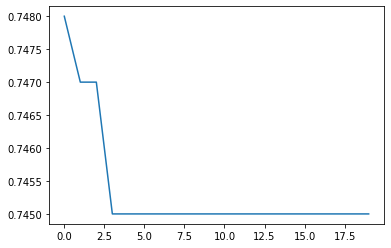

In [25]:
# quick look
plt.plot(Accuracies)
print(Accuracies)
print(Cs)


In [26]:
# fit SVM

h1 = svm.SVC(kernel='rbf', C=1, gamma='scale')
h1.fit(X_train,y_train)
print("Score is: " + str(h1.score(X_test,y_test)))

# not bad, but let's see if something else works better.


Score is: 0.7626105044201769


With 3 groups of individuals who are serious about their religious status, the classifier is performing with 76% accuracy. This is a **huge improvement** over the original 25%!

One option to try improving the classifier is to **make the system completely binary** by lumping atheism and agnosticism together. This would reduce the target to religious vs. nonreligious. Of course, we don't want to risk making the classifier **too simplistic**, as it will no longer be informative.

### Using Other Classifiers:

In addition to the SVM, we ran the same data through a randomforest and Naive Bayes to see if there was any significant difference in the accuracy. As it turns out it was **about the same with randomforest**, and **Naive Bayes performed with much lower accuracy** at 54.2%.

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)
trained_forest = forest.fit(X_train, y_train)

y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = trained_forest.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

# about the same

Accuracy on training data=  0.7950052029136316
Accuracy on test data=  0.75065002600104


In [28]:
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_test, y_pred, average ='macro')


0.5426268699724109

#### Feature Importance

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Variable','Score']
print(featureScores.sort_values("Score", ascending=False))  #print best features


                 Variable       Score
8         drugs_sometimes  212.180696
2            drinks_often   89.545863
6             drugs_never   48.338981
13             smokes_yes   25.751481
1       drinks_not at all   20.317949
3           drinks_rarely   15.904310
12   smokes_when drinking    4.358407
7             drugs_often    3.495767
9               smokes_no    3.224041
5       drinks_very often    1.434365
4         drinks_socially    0.373772
0      drinks_desperately    0.193669
11  smokes_trying to quit    0.021718
10       smokes_sometimes    0.008545


The top feature is whether the person uses drugs sometimes, followed by whether they drink often.

## Feature Co-occurence Matrix (Visual Exploratory Data)

One thought for analysis we had was to check **how often two features occur together.** For example: how often do the features of disliking cats and being female occur together? These can be visualized through a co-occurence matrix. It is also an interesting statistical experiment because you can use Naive Bayes to make predictions when you have the co-occurence data. In other words, you can answer a question like this: given that you are female, what is the probability that you dislike cats?

It is difficult to work with a many-dimensional data set like this one for feature co-occurence, so we only **chose a subset of the available features** to work on. The features we chose are: pet and children preferences, education level, occupation (this had to be binned into just a few categories), and gender.

The first code blocks are a few long functions to help parse through the categorical features and create a dataframe from the answers. We bin answers into groups (in the case of education and occupation) and one hot key encode simultaneously in the functions. 

In [30]:
#creates lists to determine if the profiles is marked to like cats or dogs

likes_dogs = []
dislike_dogs = []
dislike_cats = []

def cat_attack(this_list):
    likes_cats = []
    for x in range(0,len(this_list)):
        if ('has cats' in str(this_list[x])) == True:
            likes_cats.append(1)
        elif ('likes cats' in str(this_list[x])) == True:
            likes_cats.append(1)
        elif ('nan' in str(this_list[x])) == True:
            likes_cats.append(None)
        else:
            likes_cats.append(0)
    return likes_cats

def dog_attack(this_list):
    likes_dogs = []
    for x in range(0,len(this_list)):
        if ('has dogs' in str(this_list[x])) == True:
            likes_dogs.append(1)
        elif ('likes dogs' in str(this_list[x])) == True:
            likes_dogs.append(1)
        elif ('nan' in str(this_list[x])) == True:
            likes_dogs.append(None)
        else:
            likes_dogs.append(0)
    return likes_dogs

def dog_hate(this_list):
    dislikes_dogs = []
    for x in range(0,len(this_list)):
        if ('dislikes dogs' in str(this_list[x])) == True:
            dislikes_dogs.append(1)
        elif ('nan' in str(this_list[x])) == True:
            dislikes_dogs.append(None)
        else:
            dislikes_dogs.append(0)
    return dislikes_dogs

def cat_hate(this_list):
    dislikes_cats = []
    for x in range(0,len(this_list)):
        if ('dislikes cats' in str(this_list[x])) == True:
            dislikes_cats.append(1)
        elif ('nan' in str(this_list[x])) == True:
            dislikes_cats.append(None)
        else:
            dislikes_cats.append(0)
    return dislikes_cats


like_cat = cat_attack(df['pets'])
like_dog = dog_attack(df['pets'])
dislike_dog = dog_hate(df['pets'])
dislike_cats = cat_hate(df['pets'])

In [31]:
sexes = df[["sex"]]
sexes = sexes.replace(to_replace="m", value="0",regex=True)
sexes = sexes.replace(to_replace="f", value="1",regex=True)
sexes = sexes['sex'].tolist()

In [32]:
#functions to categorize people who have/want children

def has_children(this_list):
    output = []
    for x in range(0,len(this_list)):
        if ('has kids' in str(this_list[x])) == True:
            output.append(1)
        elif ('has a kid' in str(this_list[x])) == True:
            output.append(1)
        elif ("doesn't have kids" in str(this_list[x])) == True:
            output.append(0)
        elif ('nan' in str(this_list[x])) == True:
            output.append(None)
        else:
            output.append(None)
    return output

def wants_children(this_list):
    output = []
    for x in range(0,len(this_list)):
        if ('but wants them' in str(this_list[x])) == True:
            output.append(1)
        elif ("but might want them" in str(this_list[x])) == True:
            output.append(1)
        elif ("want kids" in str(this_list[x])) == True:
            output.append(1)
        elif ("might want more" in str(this_list[x])) == True:
            output.append(1)
        elif ("doesn't want kids" in str(this_list[x])) == True:
            output.append(0)
        elif ("doesn't want more" in str(this_list[x])) == True:
            output.append(0)
        elif ("doesn't want any" in str(this_list[x])) == True:
            output.append(0)
        elif ('nan' in str(this_list[x])) == True:
            output.append(None)
        else:
            output.append(None)
    return output

has_kids_list = []
wants_kids_list = []

has_kids_list = has_children(df['offspring'])
wants_kids_list = wants_children(df['offspring'])

In [33]:
# function to organize occupation
def occupation(this_list):
    output = []
    for x in range(0,len(this_list)):
        if ('student' in str(this_list[x])) == True:
            output.append('student')
        elif ("software" in str(this_list[x])) == True:
            output.append('stem')
        elif ("science" in str(this_list[x])) == True:
            output.append('stem')
        elif ("computer" in str(this_list[x])) == True:
            output.append('stem')
        elif ("engineering" in str(this_list[x])) == True:
            output.append('stem')
        elif ("tech" in str(this_list[x])) == True:
            output.append('stem')
        elif ("artistic" in str(this_list[x])) == True:
            output.append('art')
        elif ("musical" in str(this_list[x])) == True:
            output.append('art')
        elif ("writer" in str(this_list[x])) == True:
            output.append('art')
        elif ("medicine" in str(this_list[x])) == True:
            output.append('health')
        elif ("health" in str(this_list[x])) == True:
            output.append('health')
        elif ("financial" in str(this_list[x])) == True:
            output.append('finance')
        elif ("banking " in str(this_list[x])) == True:
            output.append('finance')
        elif ("sales" in str(this_list[x])) == True:
            output.append('finance')
        elif ("education" in str(this_list[x])) == True:
            output.append('education')
        elif ("academia" in str(this_list[x])) == True:
            output.append('education')
        elif ('nan' in str(this_list[x])) == True:
            output.append(None)
        else:
            output.append('other')
    return output

ocupation_list = []
occupation_list = occupation(df['job'])
print(len(occupation_list))

59946


In [34]:
#crates list of education level
def education_level(this_list):
    output = []
    for x in range(0,len(this_list)):
        if ('working on college' in str(this_list[x])) == True:
            output.append('college')
        elif ('graduated from college' in str(this_list[x])) == True:
            output.append('college')
        elif ("working on masters program" in str(this_list[x])) == True:
            output.append('masters')
        elif ("graduated from masters program" in str(this_list[x])) == True:
            output.append('masters')
        elif ("two-year" in str(this_list[x])) == True:
            output.append('college')
        elif ("ph.d program" in str(this_list[x])) == True:
            output.append('phd')
        elif ("dropped" in str(this_list[x])) == True:
            output.append('no college')
        elif ("space camp" in str(this_list[x])) == True:
            output.append('no college')
        elif ('nan' in str(this_list[x])) == True:
            output.append(None)
        else:
            output.append(None)
    return output

education_list = []
education_list = education_level(df['education'])

In [35]:
# this makes a list of income level
def income_level(this_list):
    output = []
    for x in range(0,len(this_list)):
        if df['income'][x] == (-1):
            output.append(None)
        elif df['income'][x] < 20000 and df['income'][x] > 0:
            output.append('Poverty')
        elif df['income'][x] < 45000 and df['income'][x] >= 20000:
            output.append('Low')
        elif 45000 <= df['income'][x] < 140000:
            output.append('Middle')
        elif df['income'][x] >= 140000:
            output.append('Wealthy')
        else:
            output.append(None)
    return output
income_list = []
income_list = income_level(df['income'])



In [36]:
correlations = pd.DataFrame({"LikesCats" : like_cat,
                             "DislikesCats" : dislike_cats,
                             "LikesDogs": like_dog,
                             "DislikesDogs" : dislike_dog,
                             "HasChildren": has_kids_list,
                             "WantsChildren": wants_kids_list,
                             "Job": occupation_list,
                             "Education": education_list,
                             "Income": income_list,
                             "Sex": sexes})

correlations.head()


,LikesCats,DislikesCats,LikesDogs,DislikesDogs,HasChildren,WantsChildren,Job,Education,Income,Sex
0,1.0,0.0,1.0,0.0,0.0,1.0,other,college,None,0
1,1.0,0.0,1.0,0.0,0.0,1.0,other,no college,Middle,0
2,1.0,0.0,0.0,0.0,NaN,NaN,None,masters,None,0
3,1.0,0.0,0.0,0.0,NaN,1.0,student,college,Low,0
4,1.0,0.0,1.0,0.0,NaN,NaN,art,college,None,0


Sex               0        1
LikesDogs                   
0.0        0.060993  0.06969
1.0        0.939007  0.93031


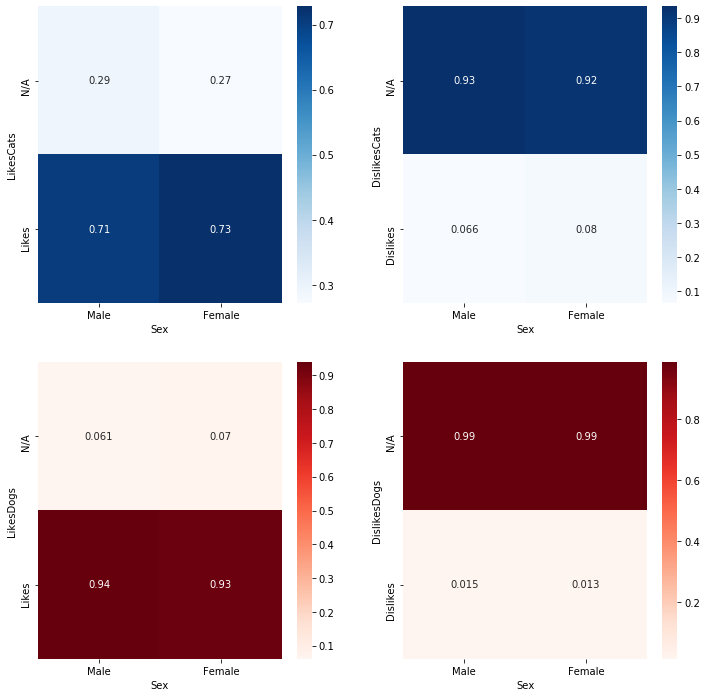

In [37]:
# create co-occurence matrices and heatmaps to visualize pet data with genders

cat_like_comat = pd.crosstab(correlations.LikesCats, correlations.Sex).apply(lambda r: r/r.sum(), axis=0)
cat_dislike_comat = pd.crosstab(correlations.DislikesCats, correlations.Sex).apply(lambda r: r/r.sum(), axis=0)
dog_like_comat = pd.crosstab(correlations.LikesDogs, correlations.Sex).apply(lambda r: r/r.sum(), axis=0)
dog_dislike_comat = pd.crosstab(correlations.DislikesDogs, correlations.Sex).apply(lambda r: r/r.sum(), axis=0)

xlab=["Male", "Female"]
ylike=["N/A", "Likes"]
ydislike=["N/A", "Dislikes"]

f, axes = plt.subplots(2, 2, figsize=(12,12))

print(dog_like_comat)

sns.heatmap(cat_like_comat, cmap="Blues", ax=axes[0,0], xticklabels=xlab, yticklabels=ylike, annot=True)
sns.heatmap(cat_dislike_comat, cmap="Blues", ax=axes[0,1],xticklabels=xlab, yticklabels=ydislike, annot=True)
sns.heatmap(dog_like_comat, cmap="Reds", ax=axes[1,0],xticklabels=xlab, yticklabels=ylike, annot=True)
sns.heatmap(dog_dislike_comat, cmap="Reds", ax=axes[1,1],xticklabels=xlab, yticklabels=ydislike, annot=True)


We can gather from this data that **most people are reluctant to admit they dislike dogs or cats**, and the **genders are split pretty evenly** when you look at the individual categories. More people like dogs than cats.

Note: For "Dislikes Dogs" N/A encompasses all the people who a) like dogs or b) did not put whether they like dogs or dislike them. 

Another important note: we are NOT working with absolute values and are using percentages instead. This means that we are talking about 1.3% of female profiles in the dataset, not 1.3% of total. 

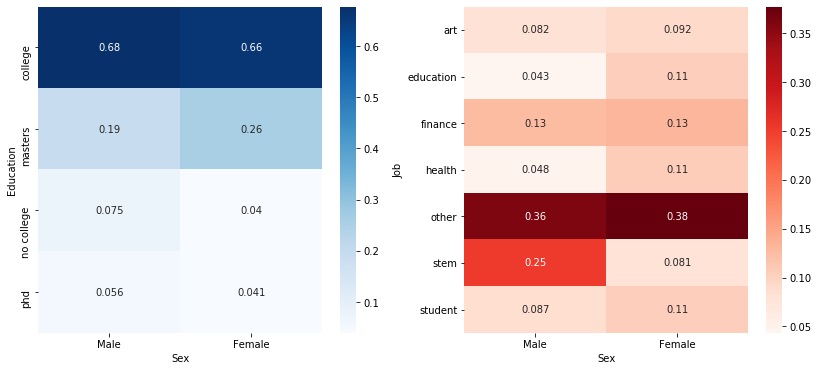

In [38]:
education_comat = pd.crosstab(correlations.Education, correlations.Sex).apply(lambda c: c/c.sum(), axis=0)
occupation_comat = pd.crosstab(correlations.Job, correlations.Sex).apply(lambda c: c/c.sum(), axis=0)

xlab=["Male", "Female"]
ylike=["Likes", "No Opinion"]
ydislike=["No Opinion", "Dislikes"]

f, axes = plt.subplots(1, 2, figsize=(14,6))


sns.heatmap(education_comat, cmap="Blues", ax=axes[0], xticklabels=xlab, annot=True)
sns.heatmap(occupation_comat, cmap="Reds", ax=axes[1],xticklabels=xlab,annot=True)


Here, we examine the different frequency of occupation type and education level between the two genders.

Notable differences: **26% of females reported attaining a master's degree vs. only 19% of males** reported the same. In the occupation field, **25% of males report a STEM-related occupation, while only 8.1% of females** report STEM occupations. **Health and education, however, are female dominated** at 11% each--compared to 4.3% and 4.8% respectively for males. 

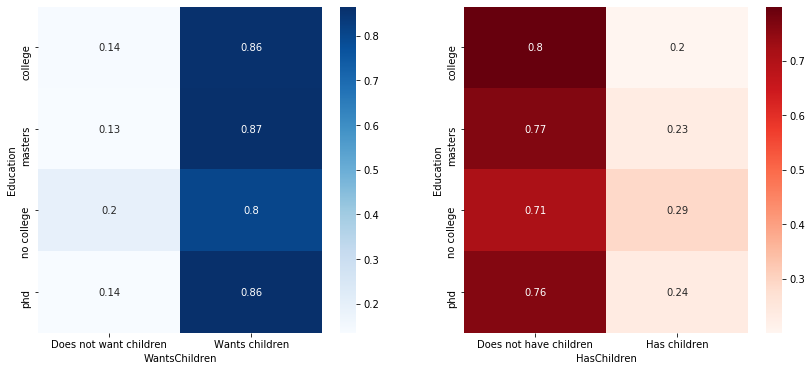

In [39]:
wants_children_comat = pd.crosstab(correlations.Education, correlations.WantsChildren).apply(lambda r: r/r.sum(), axis=1)
has_children_comat = pd.crosstab(correlations.Education, correlations.HasChildren).apply(lambda r: r/r.sum(), axis=1)


xlabwant=["Does not want children", "Wants children"]
xlabhave=["Does not have children", "Has children"]



f, axes = plt.subplots(1, 2, figsize=(14,6))


sns.heatmap(wants_children_comat, cmap="Blues", ax=axes[0], xticklabels=xlabwant, annot=True)
sns.heatmap(has_children_comat, cmap="Reds", ax=axes[1],xticklabels=xlabhave,annot=True)




We also took a look at child preferences compared against their education level. Whether people want/have children seems to be **pretty evenly spread across different education levels**. There is very little variation between the groups. **Most people on OkCupid do not have children, but want them** (makes sense, as this is a dating website). 

## Clustering Zodiac Signs

Since clustering is an unsupervised machine learning method, we can pretty much ignore the ground truth labels in the dataset. We will simply try to cluster the data (using the "about me" essays) into 12 clusteres (1 for each sign).

In [40]:
# pare the df down to features we care about

full = len(df)
zodiac = df[df["sign"].notna()]
removed = len(zodiac)
print(full - removed)

zodiac = zodiac.loc[:, ["sign", "essay0"]]
zodiac = zodiac.dropna()
features = zodiac.drop(columns=["sign"])
features = features.reset_index(drop=True)

# now we need the target
target = zodiac["sign"]

target = target.str.split(n=1)
target = target.reset_index(drop=True)
target[0:5]


11056


0                           [gemini]
1                           [cancer]
2    [pisces, but it doesn't matter]
3                           [pisces]
4                         [aquarius]
Name: sign, dtype: object

In [41]:
targets = []

for item in target:
    targets.append(item[0])

print(targets[0:5])

zodiac["sign"] = targets
zodiac.head()


['gemini', 'cancer', 'pisces', 'pisces', 'aquarius']


,sign,essay0
0,gemini,about me: i would love to think that i was so...
1,cancer,i am a chef: this is what that means. 1. i am ...
2,pisces,"i'm not ashamed of much, but writing public te..."
3,pisces,i work in a library and go to school. . .
4,aquarius,hey how's it going? currently vague on the pro...


For fun, let's see some of the most common words used by one sign (that don't appear in the general top common words of all the essays).

In [42]:
# quick look at unique words used by the coolest sign ;)

sagittarius = zodiac[zodiac["sign"] == 'sagittarius']

sagittarius_most_common, sagittarius_tokenized = analyze(sagittarius)

all_most_common, all_tokenized = analyze(df)

sagittarius_unique = list(set(sagittarius_most_common["Most Common Words"]) - set(all_most_common["Most Common Words"]))

sagittarius_unique[0:10]


Total number of essays: 3629
Number of essays lost is: 0
Total number of essays: 59946
Number of essays lost is: 5488


['intelligence',
 'france',
 'process',
 'longer',
 'lead',
 'imagine',
 'international',
 'india',
 'emotionally',
 'taste']

In [43]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(zodiac["essay0"])


In [44]:
# PCA is bad with sparse matrices, so we are using TruncatedSVD

X = vectors
y = zodiac["sign"]

svd = TruncatedSVD()
principalComponents = svd.fit_transform(X)

# store in dataframe
SVD_DF = pd.DataFrame(data = principalComponents)


In [45]:
# print the explained variance ratios
var_ratio = svd.explained_variance_ratio_
print(var_ratio)


[0.14607356 0.06603497]


The **explained variance ratio is pretty abysmal**. But let's try to continue with the clustering in any case. Sometimes **not finding a relationship between two variables is as informative as finding a relationship.**

If we were walking into this blind and we wanted to know how many clusters Kmeans would work best with, we would try a silhouette plot and choose the best n_clusters value. But **we already know that we want 12 clusters** (1 for each sign), so we will skip that.

In [46]:
X = SVD_DF
y_pred = KMeans(n_clusters=12).fit_predict(X)


Text(0, 0.5, 'principal component 2')

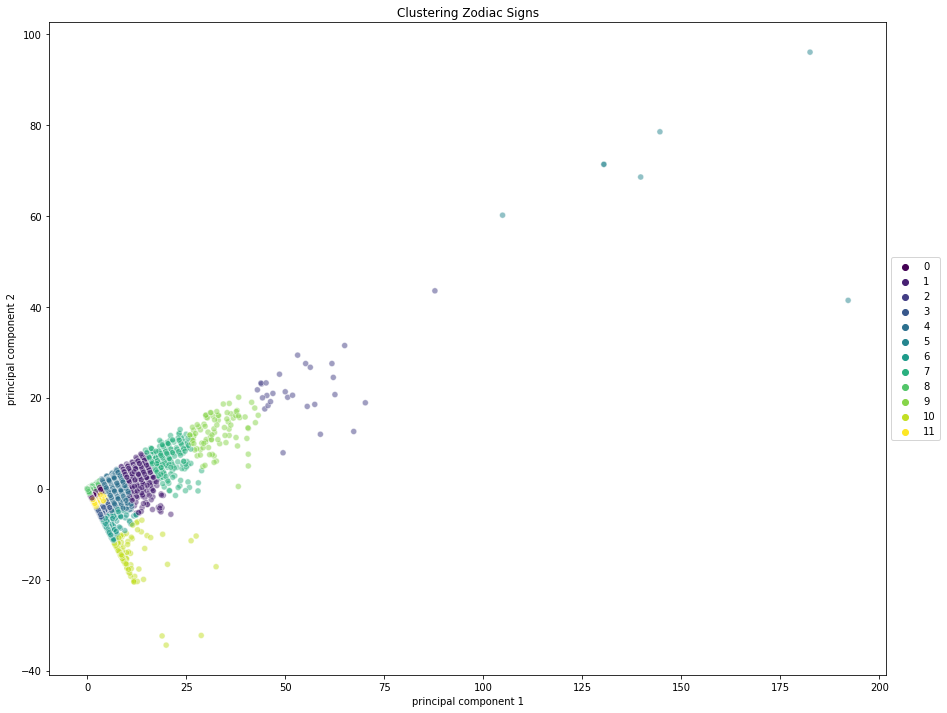

In [47]:
plt.figure(figsize=(15,12))

s = sns.scatterplot(X.iloc[:,0], X.iloc[:,1], 
                    hue=y_pred, legend="full", palette="viridis", alpha=0.5)
s.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.title('Clustering Zodiac Signs')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')


It's pretty clear that **there are no defined clusters...** at all. We feel confident in saying that it would be difficult to build a classifier or to accurately cluster the essays with zodiac signs as the ground truth. From this, we can draw a tentative conclusion that what OkCupid users write in the "about me" isn't influenced by their zodiac sign in a significant way.

In [48]:
t2 = time.time()


In [49]:
print("Code run time: " + str(t2-t1) + " seconds")


Code run time: 390.1845700740814 seconds


# Conclusion

   It was interesting to find that **the essays were more similar than they were different**. That is to say that the **top words by frequency were almost the same**. This makes sense as everyone is writing within the same domain (ie they are presenting themselves on a dating app with the hope of attracting a romantic partner). However, the differences are the interesting parts. It seems, as stated above, that **female marked profiles tend to emphasize ideals and values while male marked profiles tend to emphasize activities and hobbies**. We weren't able to classify gender anywhere beyond 70% accuracy which is not entirely surprising. There is enough variability expected between profiles that getting beyond that number would be surprising.  We learned that **there are differences between the essays of male and female profiles, but they are not so distinct as to be able to predict them very accurately. **
    
   When it came to **religious profiles we were able to accurately categorize them with about 76% accuracy** using the data from reported drug use, drinking, and smoking. This was fairly impressive and from it we learned that **those who were more 'seriously religious' were less likely to say that they use drugs, consume alcohol, or smoke.** Whether or not this would be indicative of actual behavior in the real world is impossible for us to say, but at the very least **the reported behaviors are different**. Finally, our attempt to find **clusters among zodiacal signs came up empty**. The most generous interpretation of this would be to say that birth month was not predictive of anything. A less kind way of saying would be that zodiacal signs are meaningless, at least within this dataset. 